<a href="https://colab.research.google.com/github/tonyjoo974/mask-rcnn-using-synthetic-models/blob/master/src/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Dataset and Dependencies

In [ ]:
#download datasets
%cd /content/
!gdown --id 1vVRljsIjX2UafAoM2SfucLBh-ufs6UxQ
!rm -r /content/dataset
!unzip -q dataset.zip
%pushd /content/dataset/real/
!bash /content/drive/MyDrive/CS543_Group/split_val val 500 > /dev/null
%popd

In [ ]:
!pip install -q segmentation-models-pytorch pytorch-lightning

# Load

In [ ]:
# add path for python helper codes
import sys
sys.path += ['/content/drive/MyDrive/CS543_Group/src']

from PIL import Image, ImageOps
from torch.utils.data import random_split
from IPython.display import display, clear_output
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import segmentation_models_pytorch as smp
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import math
import pytorch_lightning as pl

assert torch.cuda.is_available()

FIGSIZE = (15,7)
%matplotlib inline
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
import model_wrapper
import dataset_loader
import evaluation
import mask_rcnn
%load_ext autoreload
%autoreload 2

In [ ]:
spacial_transforms=[transforms.RandomVerticalFlip(), 
                    transforms.RandomHorizontalFlip(),
                    transforms.Pad(40),
                    transforms.RandomResizedCrop(448, scale=(0.8,1.0))]

def create_dataloader(dataset, shuffle=False):
  return DataLoader(dataset, batch_size=8, shuffle=shuffle, num_workers=4)

dataset_real_train = dataset_loader.DatasetSegmentation('/content/dataset/real/train', spacial_transforms=spacial_transforms)
dataset_real_val = dataset_loader.DatasetSegmentation('/content/dataset/real/val')
dataset_real_test = dataset_loader.DatasetSegmentation('/content/dataset/real/test')

dataloader_real_train = create_dataloader(dataset_real_train, True)
dataloader_real_val = create_dataloader(dataset_real_val)
dataloader_real_test = create_dataloader(dataset_real_test)

dataset_synthetic_train = dataset_loader.DatasetSegmentation('/content/dataset/synthetic/train', spacial_transforms=spacial_transforms)
dataset_synthetic_val = dataset_loader.DatasetSegmentation('/content/dataset/synthetic/test')

dataloader_synthetic_train = create_dataloader(dataset_synthetic_train, True)
dataloader_synthetic_val = create_dataloader(dataset_synthetic_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
base_mrcnn = mask_rcnn.get_model_instance_segmentation()

In [ ]:
!mkdir -p /content/mask_rcnn
%cd /content/mask_rcnn
maskrcnn = mask_rcnn.MaskRCNNModel(base_mrcnn)
trainer = pl.Trainer(accelerator="gpu", gpus=1, auto_scale_batch_size="power",)
# trainer.fit(maskrcnn, dataloader_real_train, dataloader_real_val, ckpt_path="/content/drive/MyDrive/CS543_Group/maskrcnn/version_2/checkpoints/epoch=2-step=1499.ckpt")

In [ ]:
trainer.validate(maskrcnn, dataloader_real_val, ckpt_path="/content/drive/MyDrive/CS543_Group/maskrcnn/version_0/checkpoints/epoch=9-step=4999.ckpt")

Restoring states from the checkpoint path at /content/drive/MyDrive/CS543_Group/maskrcnn/version_0/checkpoints/epoch=9-step=4999.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/drive/MyDrive/CS543_Group/maskrcnn/version_0/checkpoints/epoch=9-step=4999.ckpt


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_iou': 0.7070651054382324}
--------------------------------------------------------------------------------


[{'val_iou': 0.7070651054382324}]

In [ ]:
maskrcnn_test_predictions = trainer.predict(maskrcnn, dataloader_real_test, ckpt_path="/content/drive/MyDrive/CS543_Group/maskrcnn/version_0/checkpoints/epoch=9-step=4999.ckpt")

Restoring states from the checkpoint path at /content/drive/MyDrive/CS543_Group/maskrcnn/version_0/checkpoints/epoch=9-step=4999.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at /content/drive/MyDrive/CS543_Group/maskrcnn/version_0/checkpoints/epoch=9-step=4999.ckpt
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Predicting: 53it [00:00, ?it/s]

In [ ]:
maskrcnn_test_predictions[0].dtype

torch.float32

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


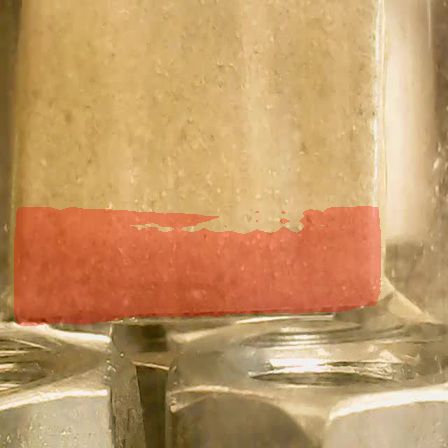

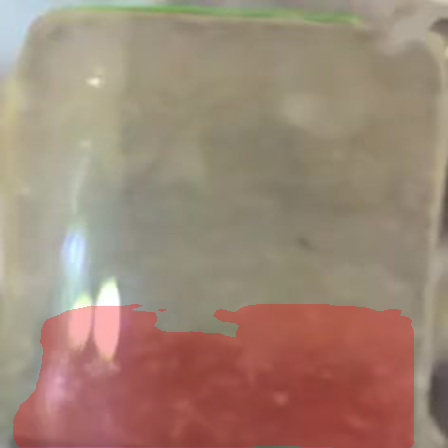

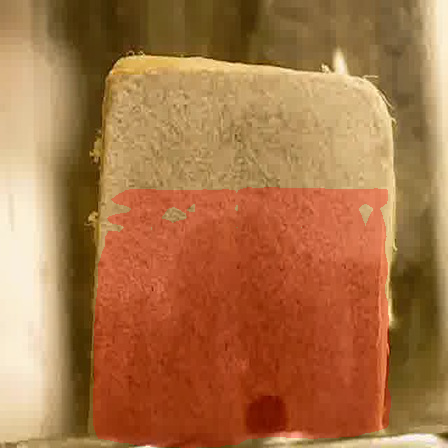

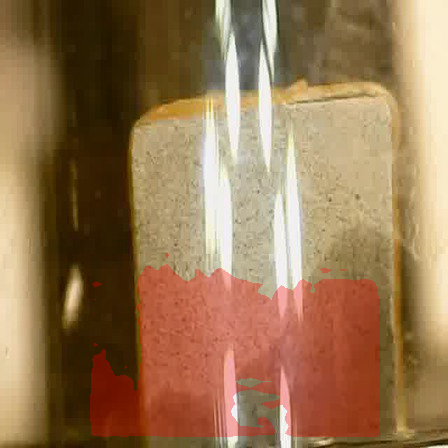

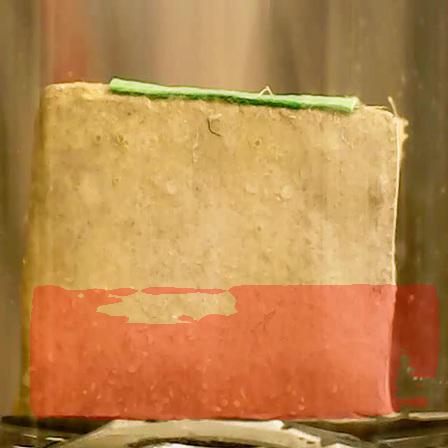

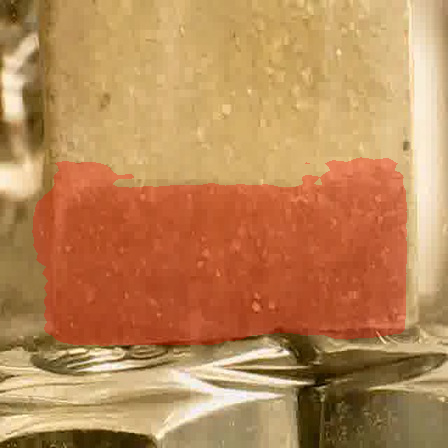

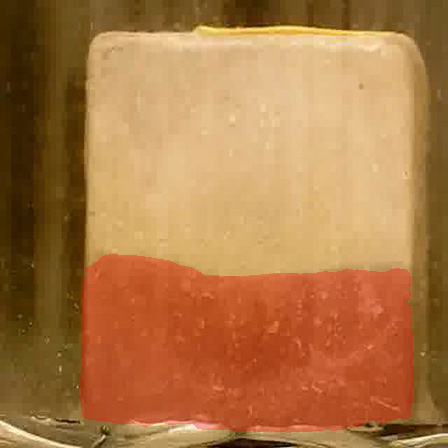

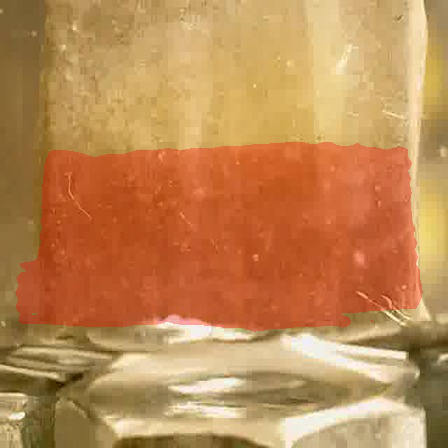

In [ ]:
to_pil = transforms.ToPILImage()

for idx,(x_b,_),y_b in zip(range(1), dataloader_real_test, maskrcnn_test_predictions):
  for im, pred in zip(x_b, y_b):
      im = (im * 255).byte()

      mask = pred > 0.5

      im = torchvision.utils.draw_segmentation_masks(im, mask, alpha=0.3, colors='red')

      pil_im = to_pil(im)
      display(pil_im)


In [ ]:
validate(smp_unet, SMP_STANDARDIZER, dataloader_real_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(0.052062905497021146, 0.9054785985795278)

In [ ]:
model_wrapper.test_reload()

bloooop


In [ ]:
smp_unet = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)
smp_unet = model_wrapper.SMPModel(smp_unet)

In [ ]:
trainer = pl.Trainer(accelerator="gpu", gpus=1, auto_scale_batch_size="power",)
trainer.fit(smp_unet, dataloader_real_train, dataloader_real_val, ckpt_path='/content/lightning_logs/version_3/checkpoints/epoch=10-step=5499.ckpt')

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Restoring states from the checkpoint path at /content/lightning_logs/version_3/checkpoints/epoch=10-step=5499.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:248: UserWarning: You're resuming from a checkpoint that ended mid-epoch. Training will start from the beginning of the next epoch. This can cause unreliable results if further training is done, consider using an end of epoch checkpoint.
  "You're resuming from a checkpoint that ended mid-epoch."
Restored all states from the checkpoint file at /content/lightning_logs/version_3/checkpoints/epoch=10-step=5499.ckpt

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 24.4 M
-------------------------------
24.4 M    Trainable params
0         Non-trainable params
24.4 M    Total params
97.745    Total esti

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:685: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
